In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob

# Zonal Mean Online Bias

In this notebook, we show how we generate zonal mean bias plots, i.e., Figure 3, 4, 5, and G1 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [1]:
data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'
data_path = '/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/'

In [3]:
ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


## Read the 5-year U-Net hybrid simulation and MMF reference simulation monthly data

In [4]:
yearstr = '5year'
yearstr = '1year'


filenames = data_path+'h0/'+yearstr+'/unet_v5/huber_rop/*.eam.h0.000[3-8]*.nc'

ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/'+yearstr+'/mmf_ref/*.eam.h0.000[3-8]*.nc'

ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

In [6]:
import numpy as np 

# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load(data_path+'microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = zonal_mean_area_weighted(idx_p400_t10, grid_area, lat)

## Visualize the 5-year mean zonal mean values and biases of state variables (e.g, T, Q) and tendency variables (e.g., dT/dt, dQ/dt)

These correspond to the Figure 4 and 5 in Hu et al. 2024.

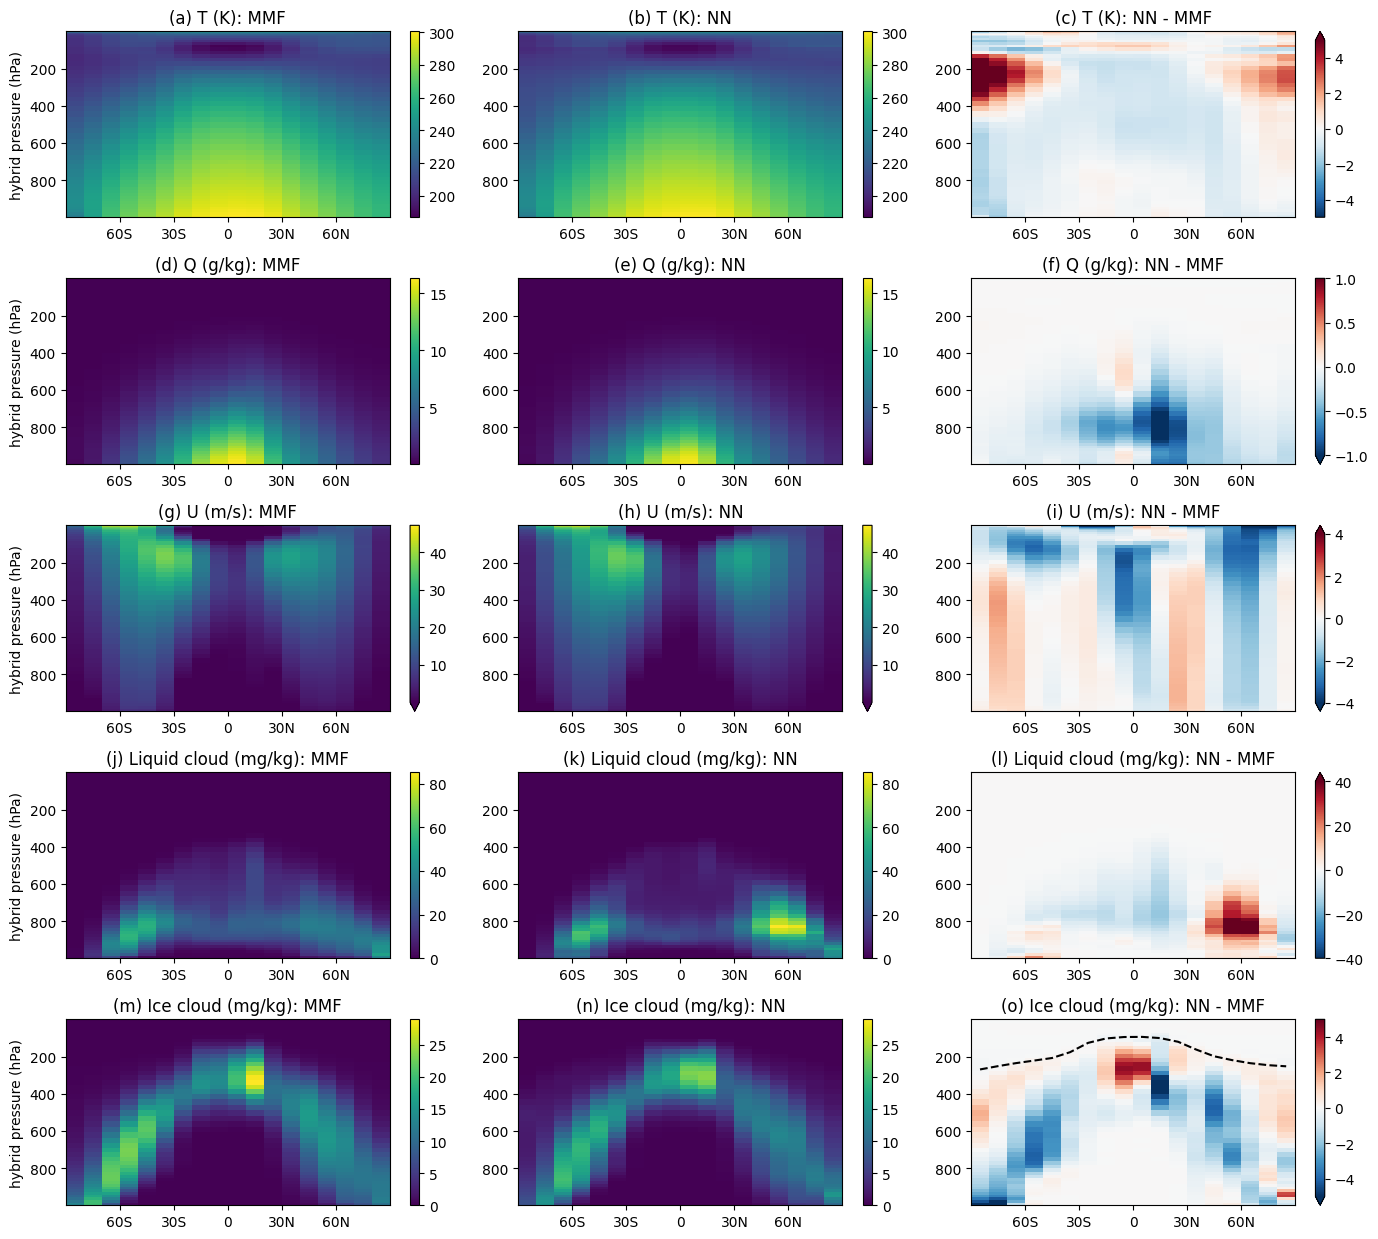

In [7]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 5},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

tropopause_pressure = idx_tropopause_zm[0].flatten()  # Flatten to 1D array
tropopause_latitude = idx_tropopause_zm[1]  # Latitude values
axs[4, 2].plot(tropopause_latitude, tropopause_pressure, 'k--')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
# plt.savefig('zonal_mean_state_bias_v5_nopruning_noclass_drop1month_addtropopause.pdf', format='pdf', dpi=400)
plt.show()


In [8]:
import matplotlib.pyplot as plt
import xarray as xr
import string

# List of variables and their settings
variables = [
    {'var': 'DTPHYS', 'var_title': 'dT/dt', 'scaling': 1., 'unit': 'K/s', 'diff_scale': 1, 'state_scale': 0.5},
    {'var': 'DQ1PHYS', 'var_title': 'dQ/dt', 'scaling': 1e3, 'unit': 'g/kg/s', 'diff_scale': 1, 'state_scale': 0.5},
    {'var': 'DUPHYS', 'var_title': 'dU/dt', 'scaling': 1., 'unit': 'm/s²', 'diff_scale': 0.25, 'state_scale': 0.16},
    {'var': 'DQnPHYS', 'var_title': 'dQn/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'diff_scale': 0.5, 'state_scale': 0.6}
]

# Combine dQc/dt and dQi/dt into dQn/dt
ds_sp['DQnPHYS'] = ds_sp['DQ2PHYS'] + ds_sp['DQ3PHYS']
ds_nn['DQnPHYS'] = ds_nn['DQ2PHYS'] + ds_nn['DQ3PHYS']

# Create a figure with subplots (4 rows x 3 columns) to rotate the figure
fig, axs = plt.subplots(4, 3, figsize=(14, 12))  # Adjust size as necessary
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:12]]

# Loop through each variable and its corresponding subplot position
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']
    state_scale = var_info['state_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp

    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    
    vmax = max(abs(vmax), abs(vmin)) * state_scale
    vmin = -vmax
    
    # Plot MMF for each variable in the first row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx*3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    # Plot NN for each variable in the second row
    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx*3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()

    # Plot NN-MMF for each variable in the third row
    vmax_diff = max(abs(data_diff).max(), abs(data_diff).min()) * diff_scale
    vmin_diff = -vmax_diff
    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx*3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()

    # Clear x-labels to clean up plot
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')
    
    if idx > 0:
        axs[idx, 0].set_ylabel('')  # Clear the y-label to clean up plot
        axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot
        axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot

# Set these ticks and labels for each subplot
latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels

plt.tight_layout()
# plt.savefig('zonal_mean_tendency_bias_reduced_nopruning_noclass_wdiff_vertical_drop1month.pdf', format='pdf', dpi=400)
plt.show()

KeyError: "No variable named 'DQ2PHYS'. Variables on the dataset include ['area', 'lev', 'hyam', 'hybm', 'P0', ..., 'PS', 'Q', 'T', 'U', 'V']"

## Read another 5-year U-Net hybrid simulation

We can see that the 5-year online bias can vary due to change of NN checkpoint, although some bias patterns remain similar (e.g., tropical dry moisture bias and negative liquid cloud bias). Figure G1 in Hu et al. 2024.

In [9]:
filenames = data_path+'h0/'+yearstr+'/unet_v5/huber_step/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/'+yearstr+'/RNN/huber_mem/*.eam.h0.000[3-8]*.nc'

ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/'+yearstr+'/mmf_ref/*.eam.h0.000[3-8]*.nc'
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

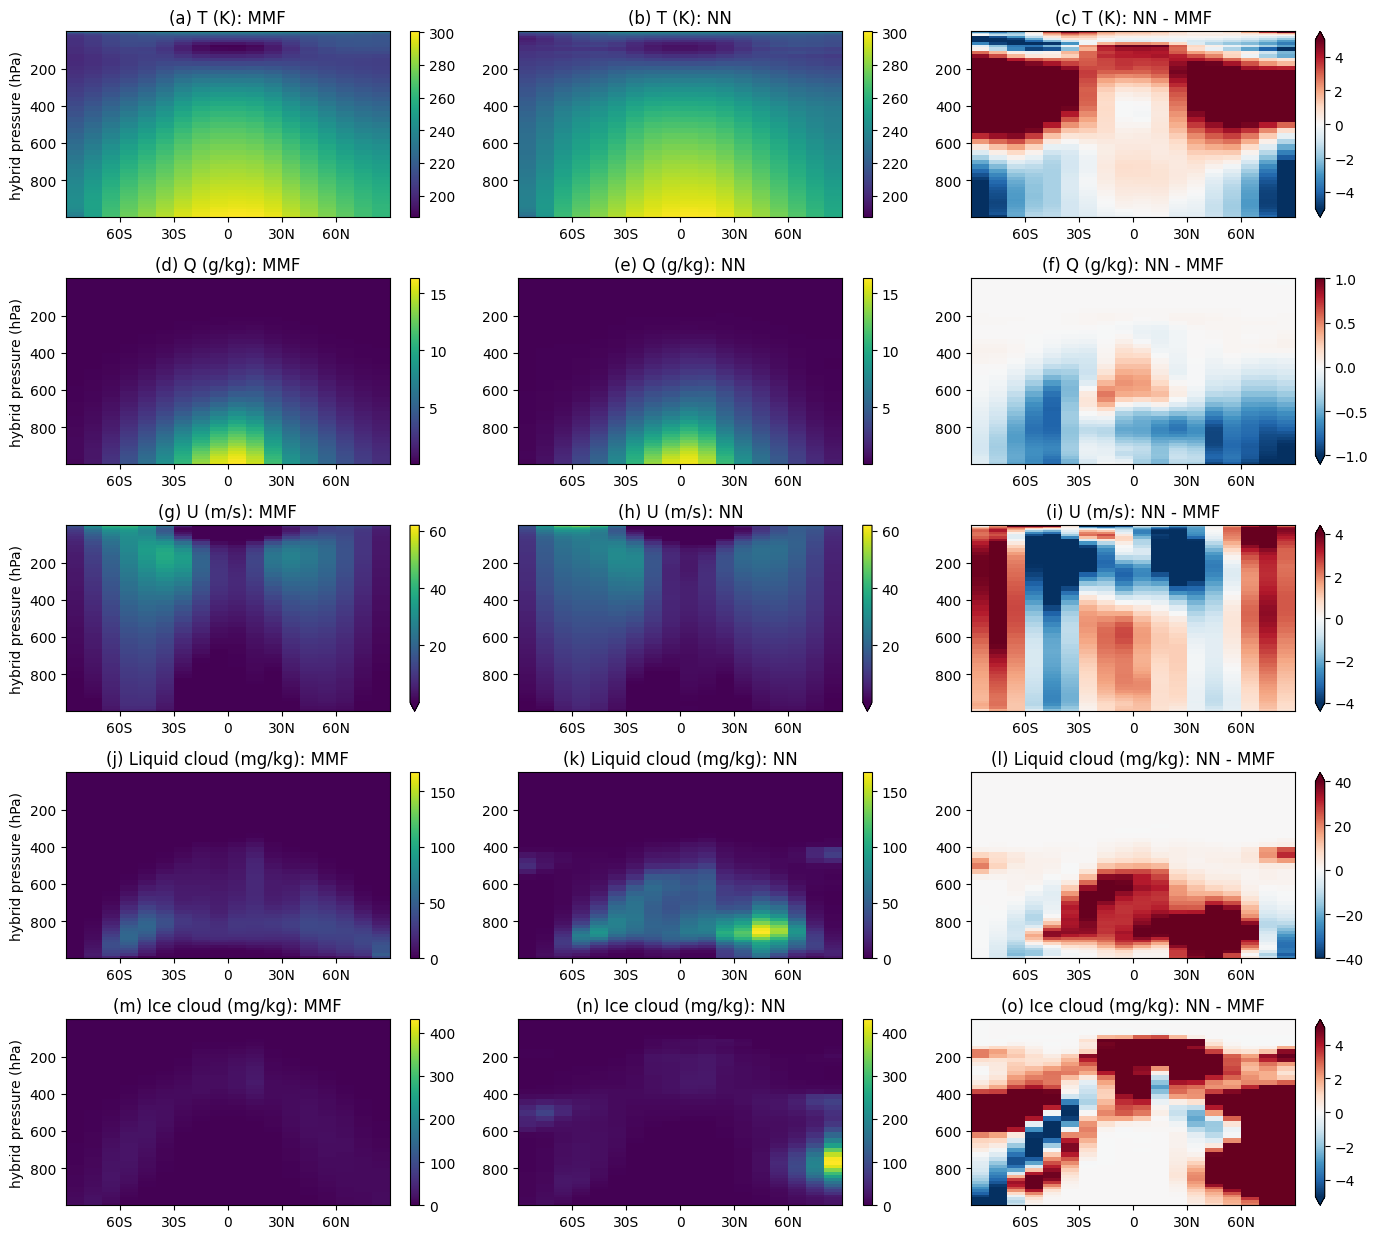

In [10]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 5},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


## Zonal mean cloud liquid and ice zonal mean bias in unconstrained U-Net hybrid simulation exploded

Below we compare a single month's cloud liquid and ice zonal mean bias in reference MMF simulation, unconstrained U-Net, and constrained U-Net hybrid simulations. This month is where we observe that the unconstrained U-Net model experience rapid error growth.

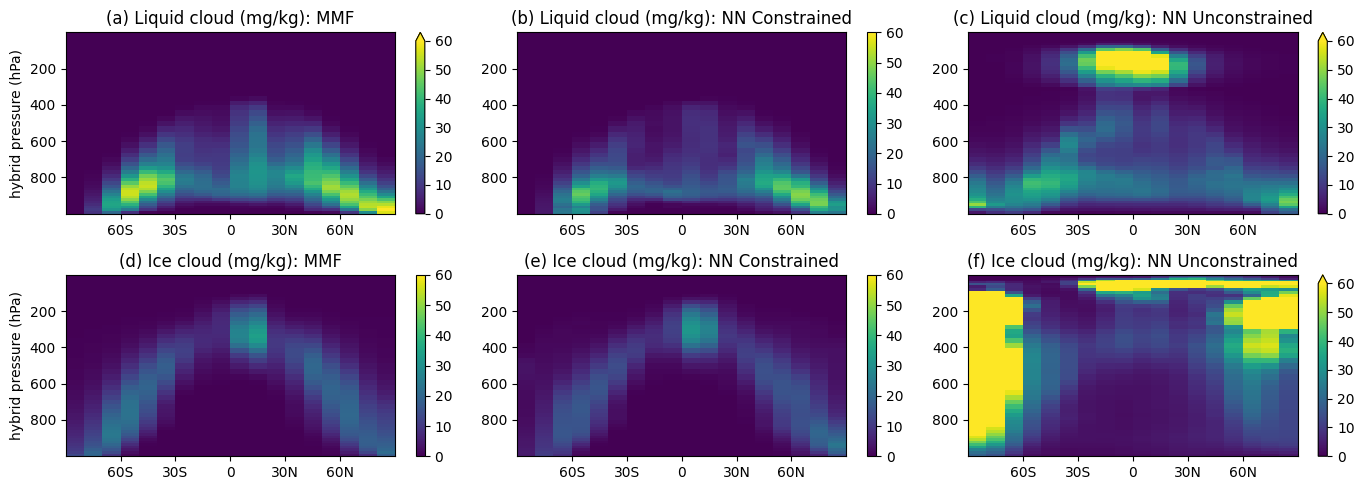

In [10]:
import matplotlib.pyplot as plt
import xarray as xr
import string

# Load the datasets
ds_sp = xr.open_dataset(data_path + 'h0/1year/mmf_ref/mmf_ref.eam.h0.0003.nc')
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'
ds_sp = ds_sp.isel(time=9)

ds_v4 = xr.open_dataset(data_path + 'h0/1year/unet_v4/huber_rop/v4_noclassifier_huber_1y_noaggressive_nomodifystqn_rop2_uoutputprune.eam.h0.0003-10.nc')
ds_v4['lev'].attrs['long_name'] = 'hybrid pressure'

ds_v5 = xr.open_dataset(data_path + 'h0/1year/unet_v5/huber_rop/v5_noclassifier_huber_1y_noaggressive_rop2.eam.h0.0003-10.nc')
ds_v5['lev'].attrs['long_name'] = 'hybrid pressure'

# List of variables and their settings for the two rows
variables = [
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 5))  # Adjust size as necessary
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:6]]

vmaxs = [60,60]

# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].compute().transpose('ncol', 'lev')
    nn_tmean_v4 = ds_v4[var][0,:,:].compute().transpose('ncol', 'lev')
    nn_tmean_v5 = ds_v5[var][0,:,:].compute().transpose('ncol', 'lev')
    
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm_v4, lats_sorted = zonal_mean_area_weighted(nn_tmean_v4, grid_area, lat)
    nn_zm_v5, lats_sorted = zonal_mean_area_weighted(nn_tmean_v5, grid_area, lat)
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn_v4 = scaling * xr.DataArray(nn_zm_v4[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn_v5 = scaling * xr.DataArray(nn_zm_v5[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})

    vmax = vmaxs[idx]
    vmin=0
    
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn_v4.plot(ax=axs[idx, 2], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN Unconstrained')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot

    
    data_nn_v5.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN Constrained')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot


    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()
